# System Identification with the ``ssid`` package

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from ssid import system, markov, realize, modes
from control.matlab import ss
from control.matlab import lsim
from control.matlab import impulse as _impulse
def impulse(*args, **kwds):
    a,t = _impulse(*args, **kwds)
    return a.squeeze(),t

## Define a SDOF system
parameter | value
----------|-------
m  | mass
k  | stiffness
c  | damping coefficient
nt | number of timesteps
dt | timestep

![sdof](./figures/sdof.png)

In [2]:
# parameters of SDOF system
mass = 1       # mass
k = 30         # stiffness
zeta = 0.01    # damping ratio
omega_n = np.sqrt(k/mass)  # natural frequency (rad/s)
c = 2*zeta*mass*omega_n    # damping coefficient

# forcing frequencies (rad/s)
omega_f = [0.017*omega_n, 0.14*omega_n, 0.34*omega_n]
print("natural period", 2*np.pi/omega_n)
print("forcing periods", [2*np.pi/omega for omega in omega_f])

natural period 1.1471474419090952
forcing periods [67.4792612887703, 8.19391029935068, 3.3739630644385152]


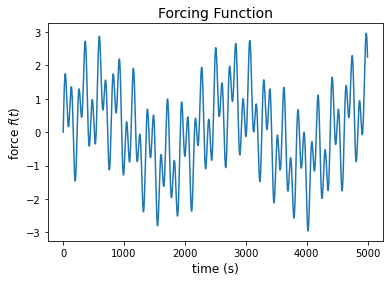

In [3]:
# forcing function
nt = 5000       # number of timesteps
dt = 0.03       # timestep
tf = nt*dt      # final time
t = np.arange(start = 0, stop = tf, step = dt)
f = np.sum(np.sin([omega*t for omega in omega_f]), axis=0)
plt.plot(f)
plt.xlabel("time (s)", fontsize=12)
plt.ylabel(r"force $f(t)$", fontsize=12)
plt.title("Forcing Function", fontsize=14);

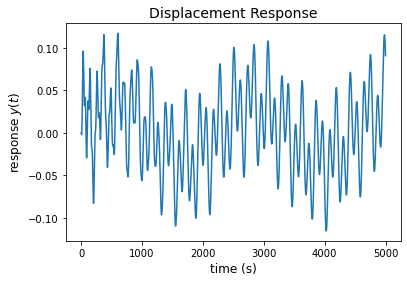

In [4]:
# displacement response (analytical solution)
omega_D = omega_n*np.sqrt(1-zeta**2)
y = np.zeros((3,nt))
for i,omega in enumerate(omega_f):
    C3 = (1/k)*(1-(omega/omega_n)**2)/((1-(omega/omega_n)**2)**2+(2*zeta*omega/omega_n))**2
    C4 = -(2*zeta*omega/omega_n)*(1-(omega/omega_n)**2)/((1-(omega/omega_n)**2)**2+(2*zeta*omega/omega_n))**2
    C1 = -C4
    C2 = (zeta*omega_n*C1-omega*C3)/omega_D
    y[i,:] = np.exp(-zeta*omega_n*t)*(C1*np.cos(omega_D*t)+C2*np.sin(omega_D*t)) + C3*np.sin(omega*t) + C4*np.cos(omega*t)
y = np.sum(y,axis=0)
plt.plot(y)
plt.xlabel("time (s)", fontsize=12)
plt.ylabel(r"response $y(t)$", fontsize=12)
plt.title("Displacement Response", fontsize=14);

In [5]:
# alternative test with El Centro motion
if False:
    import sdof
    from quakeio.elcentro import accel as elcentro
    f = elcentro.data
    dt = elcentro["time_step"]
    t = np.arange(0, f.size*dt, dt)
    *_, y = sdof.integrate(mass,c,k,f,dt)
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    ax[0].plot(f)
    ax[0].set_xlabel("time (s)", fontsize=12)
    ax[0].set_ylabel(r"force $f(t)$", fontsize=12)
    ax[0].set_title("El Centro Forcing Function", fontsize=14)
    ax[1].plot(y)
    ax[1].set_xlabel("time (s)", fontsize=12)
    ax[1].set_ylabel(r"response $y(t)$", fontsize=12)
    ax[1].set_title("Displacement Response", fontsize=14);

## Perform System Identification

In [6]:
# Generate a state space realization of the system
A,B,C,D = system.system(input=f, output=y)

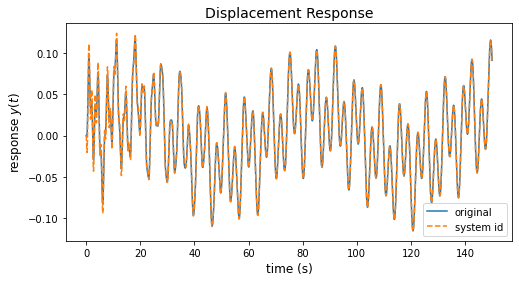

In [7]:
# Reproduce the response with the state space model
y_ssid = lsim(ss(A,B,C,D,dt),f,t)[0]
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(t,y,label="original")
ax.plot(t,y_ssid,"--",label=f"system id")
ax.set_xlabel("time (s)", fontsize=12)
ax.set_ylabel(r"response $y(t)$", fontsize=12)
ax.set_title("Displacement Response", fontsize=14)
ax.legend();

In [8]:
# Obtain natural period and damping ratio from the state space model
ss_modes = modes.modes((A,B,C,D),dt)
print("computed period:", [1/f for f in sorted([ss_modes[str(i)]['freq'] for i in list(ss_modes.keys())])])
print("natural period", 2*np.pi/omega_n)
print("period percent error:", [100*(1/f-2*np.pi/omega_n)/(2*np.pi/omega_n) for f in sorted([ss_modes[str(i)]['freq'] for i in list(ss_modes.keys())])])
print("computed damping ratio:", [d for d in [ss_modes[str(i)]['damp'] for i in list(ss_modes.keys())]])
print("damping ratio percent error:", [100*(d-zeta)/zeta for d in [ss_modes[str(i)]['damp'] for i in list(ss_modes.keys())]])

computed period: [3.386780719800223, 1.1471474419090943, 0.058775310471410325]
natural period 1.1471474419090952
period percent error: [195.2349973569139, -7.742495752961006e-14, -94.87639440893527]
computed damping ratio: [0.009999999999997877, 0.8018337087963803, 0.44537624091689826]
damping ratio percent error: [-2.123301534595612e-11, 7918.337087963803, 4353.762409168983]


## Breakdown of System Identification Methods

### General Parameters
parameter | value
----------|-------
`p ` | number of output channels
`q ` | number of input channels
`nt` | number of timesteps
`dt` | timestep

### Specific to Observer Kalman Identification (OKID)
parameter | value
----------|-------
`m`  | number of Markov parameters to compute (at most = nt)

### Specific to Eigensystem Realization Algorithm (ERA)
parameter | value
----------|-------
`no` | number of observability parameters
`nc` | number of controllability parameters
`r ` | reduced model order

### Specific to Data Correlations (DC)
parameter | value
----------|-------
`a`  | (alpha) number of additional block rows in Hankel matrix of correlation matrices
`b`  | (beta) number of additional block columns in Hankel matrix of correlation matrices
`l`  | initial lag
`g`  | lag (gap) between correlations

### Specific to System Realization with Information Matrix (SRIM)
parameter | value
----------|-------
`ns` | number of steps used for identification (prediction horizon)

In [9]:
# Set parameters
m = 300
no = 140
nc = 140
r = 2
a = 0
b = 0
l = 10
g = 3
ns = 140

In [10]:
# OKID-ERA
A,B,C,D = system.system(method="okid-era", input=f, output=y, m=m, no=no, nc=nc, r=r)
y_okid_era = lsim(ss(A,B,C,D,dt),f,t)[0]
ss_modes = modes.modes((A,B,C,D),dt)
# print("computed period:", [1/f for f in sorted([ss_modes[str(i)]['freq'] for i in list(ss_modes.keys())])])
# print("natural period", 2*np.pi/omega_n)
print("period percent error:", [100*(1/f-2*np.pi/omega_n)/(2*np.pi/omega_n) for f in sorted([ss_modes[str(i)]['freq'] for i in list(ss_modes.keys())])])
# print("computed damping ratio:", [d for d in [ss_modes[str(i)]['damp'] for i in list(ss_modes.keys())]])
print("damping ratio percent error:", [100*(d-zeta)/zeta for d in [ss_modes[str(i)]['damp'] for i in list(ss_modes.keys())]])

period percent error: [0.01798881624481967]
damping ratio percent error: [5.162734738985708]


In [11]:
# OKID-ERA-DC
A,B,C,D = system.system(method="okid-era-dc", input=f, output=y, m=m, no=no, nc=nc, r=r, a=a, b=b, l=l, g=g)
y_okid_era_dc = lsim(ss(A,B,C,D,dt),f,t)[0]
ss_modes = modes.modes((A,B,C,D),dt)
# print("computed period:", [1/f for f in sorted([ss_modes[str(i)]['freq'] for i in list(ss_modes.keys())])])
# print("natural period", 2*np.pi/omega_n)
print("period percent error:", [100*(1/f-2*np.pi/omega_n)/(2*np.pi/omega_n) for f in sorted([ss_modes[str(i)]['freq'] for i in list(ss_modes.keys())])])
# print("computed damping ratio:", [d for d in [ss_modes[str(i)]['damp'] for i in list(ss_modes.keys())]])
print("damping ratio percent error:", [100*(d-zeta)/zeta for d in [ss_modes[str(i)]['damp'] for i in list(ss_modes.keys())]])

period percent error: [0.013681263066319702]
damping ratio percent error: [-1.1478922896640196]


In [12]:
# SRIM
A,B,C,D = system.system(method="srim", input=f, output=y, ns=ns, r=r)
y_srim = lsim(ss(A,B,C,D,dt),f,t)[0]
ss_modes = modes.modes((A,B,C,D),dt)
# print("computed period:", [1/f for f in sorted([ss_modes[str(i)]['freq'] for i in list(ss_modes.keys())])])
# print("natural period", 2*np.pi/omega_n)
print("period percent error:", [100*(1/f-2*np.pi/omega_n)/(2*np.pi/omega_n) for f in sorted([ss_modes[str(i)]['freq'] for i in list(ss_modes.keys())])])
# print("computed damping ratio:", [d for d in [ss_modes[str(i)]['damp'] for i in list(ss_modes.keys())]])
print("damping ratio percent error:", [100*(d-zeta)/zeta for d in [ss_modes[str(i)]['damp'] for i in list(ss_modes.keys())]])

period percent error: [5.806871814720754e-14]
damping ratio percent error: [-1.1657341758564144e-11]


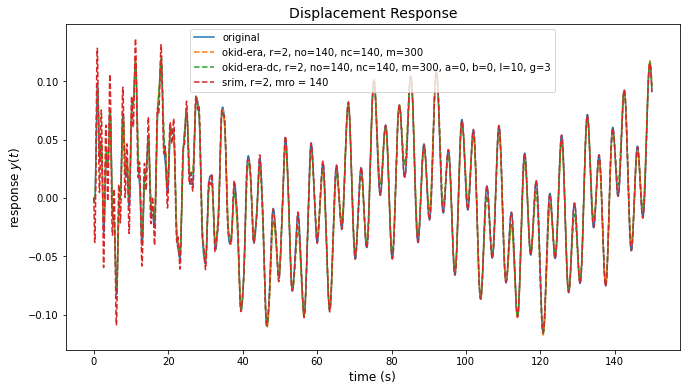

In [13]:
fig, ax = plt.subplots(figsize=(11,6))
ax.plot(t,y,label="original")
ax.plot(t,y_okid_era,"--",label=f"okid-era, {r=}, {no=}, {nc=}, {m=}")
ax.plot(t,y_okid_era_dc,"--",label=f"okid-era-dc, {r=}, {no=}, {nc=}, {m=}, {a=}, {b=}, {l=}, {g=}")
ax.plot(t,y_srim,"--",label=f"srim, {r=}, mro = {nc}")
ax.set_xlabel("time (s)", fontsize=12)
ax.set_ylabel(r"response $y(t)$", fontsize=12)
ax.set_title("Displacement Response", fontsize=14)
ax.legend();